# Detección de Fraude
---
Esta parte de la evaluación consiste en realizar un modelo de predicción de fraude.

El set de datos està en `data/fraud/creditcard_train.csv`

La evaluación es tipo *datathon* de forma que las notas se calcularán en base a:

1. Al ranking de métricas de los modelos (80%)
2. Legibilidad y presentación del código (20%)

La forma de entrega será generar un fichero csv en formato a partir de las predicciones realizadas sobre el fichero `data/fraud/creditcard_test.csv`.

| IdObservación | clase_predicha | probabilidad_clase_1 |
| ------------- | ------------- | ------------- |
|00001|True|0.6398|
|00002|True|0.5892|
|00003|False|0.2163|

EL fichero resultante tiene que tener por nombre `inicialapellido_test.csv` y se tiene que enviar por email a:

datathonuib@gmail.com

## Robert Cristea & Carlos K. Delgado

### 21/01/2018



#### Importación de librerias y lectura de los archivos

In [179]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_curve, roc_auc_score

##### Después de cargar las librerias que iré utilizando, procedo a leer los datos de entrenamiento para comenzar a trabajar con ellos:

In [4]:
data_train = pd.read_csv('data/fraud/creditcard_train.csv')
data_train.head(10)

,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,44.0,-0.948896,0.248414,2.956914,2.813750,0.145539,-0.027353,0.133702,-0.307535,...,-0.083647,0.416090,0.207537,0.716064,-0.602311,-0.064230,-0.315058,-0.272463,0.75,0
1,1,56.0,0.086996,-0.051989,-0.497882,-3.151908,2.558400,2.796671,0.470283,0.265333,...,-0.239426,-0.437342,0.018426,1.013038,-0.258927,-0.293189,-0.394956,-0.435996,10.84,0
2,2,125.0,-0.724910,0.073475,1.739547,0.758588,0.229543,2.422069,0.196688,0.861076,...,0.188696,0.738515,0.145933,-1.032186,-0.087511,-0.221063,0.108168,0.011785,113.00,0
3,3,140.0,1.175478,0.167881,0.509909,0.452332,-0.215763,-0.192104,-0.105404,0.068517,...,-0.176147,-0.500566,0.151263,0.018347,0.122003,0.106307,-0.014937,0.005771,1.29,0
4,4,196.0,1.198658,-0.420334,0.014599,-0.270793,-0.471074,-0.384610,-0.083890,-0.077570,...,-0.630206,-1.504432,0.193771,-0.017458,0.058387,0.145373,-0.034904,0.011037,63.90,0


#### Eliminar variable Index 
Observo que la columna index solo contiene los indices de filas, por lo consiguiente no es una variable a tener en cuenta en nuestro modelo.

In [6]:
data_train = data_train.drop('index', 1)
data_train.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,44.0,-0.948896,0.248414,2.956914,2.813750,0.145539,-0.027353,0.133702,-0.307535,-0.125244,...,-0.083647,0.416090,0.207537,0.716064,-0.602311,-0.064230,-0.315058,-0.272463,0.75,0
1,56.0,0.086996,-0.051989,-0.497882,-3.151908,2.558400,2.796671,0.470283,0.265333,0.919513,...,-0.239426,-0.437342,0.018426,1.013038,-0.258927,-0.293189,-0.394956,-0.435996,10.84,0
2,125.0,-0.724910,0.073475,1.739547,0.758588,0.229543,2.422069,0.196688,0.861076,0.099102,...,0.188696,0.738515,0.145933,-1.032186,-0.087511,-0.221063,0.108168,0.011785,113.00,0
3,140.0,1.175478,0.167881,0.509909,0.452332,-0.215763,-0.192104,-0.105404,0.068517,-0.249733,...,-0.176147,-0.500566,0.151263,0.018347,0.122003,0.106307,-0.014937,0.005771,1.29,0
4,196.0,1.198658,-0.420334,0.014599,-0.270793,-0.471074,-0.384610,-0.083890,-0.077570,-1.537508,...,-0.630206,-1.504432,0.193771,-0.017458,0.058387,0.145373,-0.034904,0.011037,63.90,0
5,204.0,-0.938226,0.104717,1.309642,-0.867537,0.450685,-1.437502,0.650604,0.028360,-0.588678,...,-0.237086,-1.150829,0.262462,0.475206,-0.516790,0.426883,-0.058198,0.107996,39.94,0
6,282.0,-0.669415,-0.169044,1.301837,0.370525,0.950911,-0.413911,-0.149038,0.127021,0.463116,...,0.297490,0.890770,0.012742,-0.407764,-0.678186,-0.513178,0.253350,0.254336,11.64,0
7,308.0,1.103870,-0.379365,0.699437,0.174333,-0.918021,-0.418445,-0.394106,0.061586,0.436487,...,0.008220,-0.016350,-0.050821,0.398894,0.202283,0.992404,-0.074169,0.006682,60.00,0
8,313.0,-1.038356,0.756122,0.719942,0.988402,-0.237290,-0.378862,0.413668,0.436787,-0.448178,...,0.189550,0.477872,0.298492,0.029368,-0.300420,-0.294100,-0.009905,0.038861,68.00,0
9,324.0,-0.622317,0.656826,1.094225,0.054665,0.746405,-0.973848,0.386710,-0.009876,-0.351714,...,-0.259937,-0.798558,0.000086,-0.199902,-0.062407,0.104703,0.230467,0.102421,0.89,0


#### Visualización de los datos

* Estádisticos por variable

In [175]:
data = data_train.copy() ## Hacemos una copia de los datos por precaución, así podemos manipularlo y poder recurrir
                         ## a la original en cualquier momento.
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,...,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000
mean,94413.335630,-0.192386,0.164128,-0.320883,0.214420,-0.138538,-0.045972,-0.260026,0.020558,-0.101755,...,0.036519,-0.010749,0.005431,-0.010122,0.011992,0.008631,0.010403,0.002055,89.591424,0.047619
std,47090.203021,2.539145,1.976724,2.536887,1.758363,1.861499,1.380380,2.269845,1.890984,1.307423,...,1.134010,0.786006,0.601718,0.598658,0.521701,0.487096,0.471975,0.311344,239.425840,0.212972
min,44.000000,-30.552380,-34.575064,-31.103685,-5.020488,-25.025820,-9.847370,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-15.981649,-2.766638,-3.536716,-1.480189,-7.263482,-5.706918,0.000000,0.000000
25%,54238.500000,-0.989676,-0.583268,-1.090674,-0.780131,-0.749119,-0.803048,-0.623201,-0.201921,-0.694891,...,-0.231617,-0.550772,-0.163394,-0.362282,-0.311030,-0.321798,-0.068158,-0.054186,5.000000,0.000000
50%,84863.500000,-0.023586,0.114158,0.106146,0.063112,-0.070332,-0.292343,0.011035,0.032206,-0.073247,...,-0.022282,0.001268,-0.011584,0.031144,0.031149,-0.044219,0.005249,0.013256,21.230000,0.000000
75%,138697.500000,1.297560,0.888651,0.974192,0.882648,0.598011,0.408838,0.550909,0.358243,0.585619,...,0.206964,0.521199,0.145209,0.422574,0.358695,0.264279,0.108512,0.084301,78.900000,0.000000
max,172786.000000,2.371289,22.057729,4.187811,12.114672,16.625394,14.570654,26.237722,20.007208,6.778615,...,27.202839,8.361985,17.606637,3.633399,3.410742,2.807408,4.347262,9.641075,7541.700000,1.000000


Según observamos, la columna "Amount" es la que más nos llama la atención porque tiene una desviación estándar y media mucho mayor que el resto de componentes, seguramente se debe a que los datos ya vienen preprocesados y ya recibimos las componenetes bastante estandarizadas, en cambio la variable "Amount" no es una componente por lo consiguiente es una variable original. Podría ser interesante escalar la variable para que tenga media 0 y desviación stándar 1. 

Lo mismo ocurrre con la variable "Time", que nos indica los segundos transcurridos entre cada transacción en relación a la primera, desde mi punto de vista puede ser una variable muy relevante e influyente a la hora de predecir si una transacción es fraudulenta o no, ya que los delincuentes suelen aprovechar la oportunidad para realizar repetidas retiradas y compras en un breve periodo de tiempo hasta que la víctima se da cuenta del delito y cancela la tarjeta.

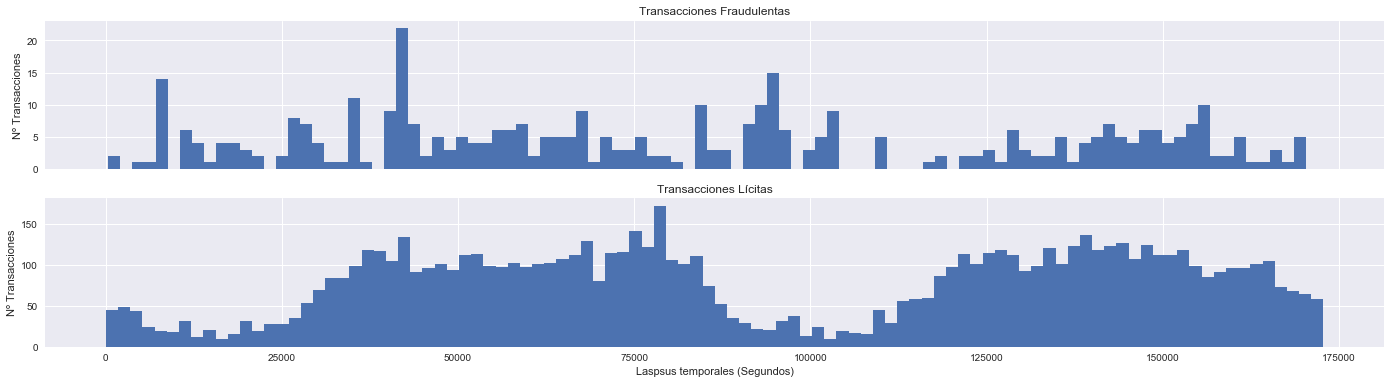

In [129]:
## Me parece curioso poder plotear como se comporta los lapsus temporales entre transacciones 
## para las transacciones con fraude y las transacciones lícitas

F, (G1, G2) = plt.subplots(2, 1, sharex = True, figsize = (24, 6))

G1.hist(data_train.Time[data_train.Class == 1], bins = 100)
G1.set_title('Transacciones Fraudulentas')
G1.set_ylabel('Nº Transacciones')

G2.hist(data_train.Time[data_train.Class == 0], bins = 100)
G2.set_title('Transacciones Lícitas')
G2.set_ylabel('Nº Transacciones')

plt.xlabel('Laspsus temporales (Segundos)')
plt.show()

Esperaba ver en las transacciones fraudulentas muchas más transaccione en lapsus menores de tiempo, si que es cierto que hay cierta diferencia entre nos dos gráficos ya que en las transacciones lícitas se aprecia que son un poco más ciclicas y periodicas que las fraudulentas. Tampoco tenemos mucha información sobre como se miden realmente estos lapsus de tiempo. No nos proporciona una gran información.

* Proporción de la clase a classificar

0    95.24
1     4.76
Name: Class, dtype: float64

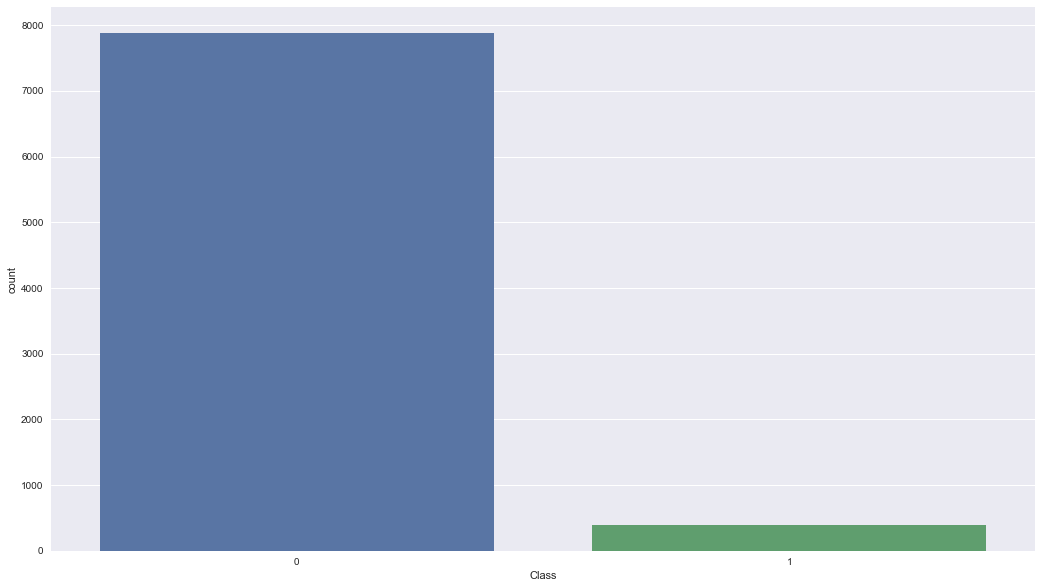

In [51]:
## Plot de la propoción de la variable objetivo
plt.figure(figsize = (60,10))
plt.subplot(131)
sns.countplot(x = 'Class', data = data)

## Proporción de la variable objetivo
value_counts = data['Class'].value_counts()
round((value_counts / sum(value_counts))*100, 2)

Se observa que los datos estan bastante desbalanceados, aproximádamente el 95% de los casos pertenecen a la clase positiva y el 5% de los casos pertenecen a la clase negativa, habrá que tenerlo en cuenta para elegir las métricas o decidir tratar los datos para equilibrar las proporciones.

* Correlaciones

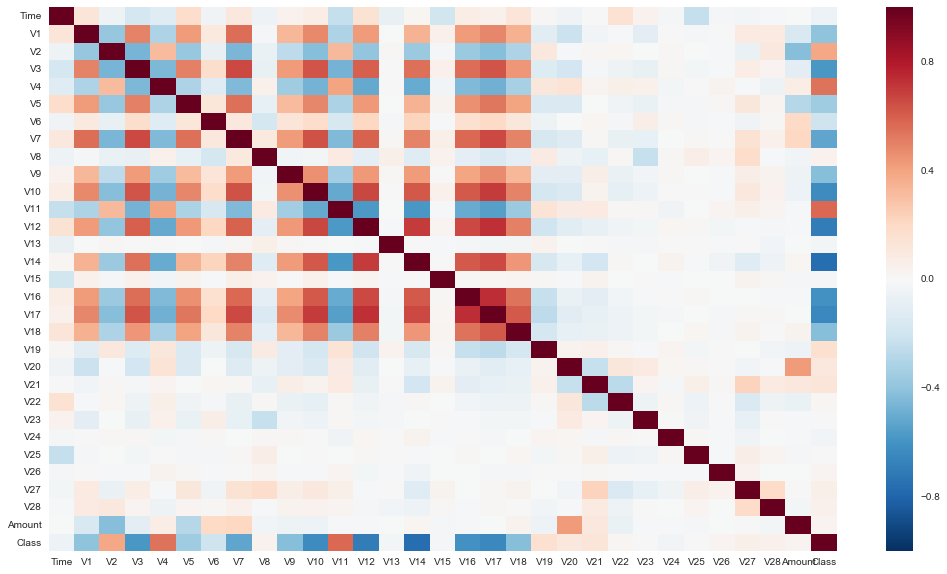

In [33]:
plt.figure(figsize = (60,10))
corr_matrix = data.corr()
feature_class_corr = pd.DataFrame(corr_matrix.loc['Class', data.columns])
plt.subplot(131)
sns.heatmap(corr_matrix)

La matriz de correlación nos muestra que no existe o hay muy poca correlación entre las variables "Time" y "Class" (fraude o no fraude), así que no cumple la expectativa previa que describo en el apartado anterior, casi que podemos prescindir de ella al igual que alguna de las componente con colores más próximos al blanco.

#### Limpieza y preparación de los datos

In [176]:
## Estandarzamos la variable Amount
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

## Eliminamos la colummna 'Time'
data.drop('Time', 1, inplace=True)

In [116]:
#Comprobamos que no haya valores nulos con los datos que vamos a trabajar para entrenar los modelos.
data.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Ninguna variable contiene valores nulos.

In [44]:
data.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.948896,0.248414,2.956914,2.813750,0.145539,-0.027353,0.133702,-0.307535,-0.125244,1.034940,...,-0.083647,0.416090,0.207537,0.716064,-0.602311,-0.064230,-0.315058,-0.272463,-0.371083,0
1,0.086996,-0.051989,-0.497882,-3.151908,2.558400,2.796671,0.470283,0.265333,0.919513,-0.735586,...,-0.239426,-0.437342,0.018426,1.013038,-0.258927,-0.293189,-0.394956,-0.435996,-0.328938,0
2,-0.724910,0.073475,1.739547,0.758588,0.229543,2.422069,0.196688,0.861076,0.099102,-0.730405,...,0.188696,0.738515,0.145933,-1.032186,-0.087511,-0.221063,0.108168,0.011785,0.097776,0
3,1.175478,0.167881,0.509909,0.452332,-0.215763,-0.192104,-0.105404,0.068517,-0.249733,0.053143,...,-0.176147,-0.500566,0.151263,0.018347,0.122003,0.106307,-0.014937,0.005771,-0.368827,0
4,1.198658,-0.420334,0.014599,-0.270793,-0.471074,-0.384610,-0.083890,-0.077570,-1.537508,0.846368,...,-0.630206,-1.504432,0.193771,-0.017458,0.058387,0.145373,-0.034904,0.011037,-0.107311,0
5,-0.938226,0.104717,1.309642,-0.867537,0.450685,-1.437502,0.650604,0.028360,-0.588678,-0.556394,...,-0.237086,-1.150829,0.262462,0.475206,-0.516790,0.426883,-0.058198,0.107996,-0.207390,0
6,-0.669415,-0.169044,1.301837,0.370525,0.950911,-0.413911,-0.149038,0.127021,0.463116,-0.595658,...,0.297490,0.890770,0.012742,-0.407764,-0.678186,-0.513178,0.253350,0.254336,-0.325596,0
7,1.103870,-0.379365,0.699437,0.174333,-0.918021,-0.418445,-0.394106,0.061586,0.436487,-0.084439,...,0.008220,-0.016350,-0.050821,0.398894,0.202283,0.992404,-0.074169,0.006682,-0.123601,0
8,-1.038356,0.756122,0.719942,0.988402,-0.237290,-0.378862,0.413668,0.436787,-0.448178,-0.346582,...,0.189550,0.477872,0.298492,0.029368,-0.300420,-0.294100,-0.009905,0.038861,-0.090185,0
9,-0.622317,0.656826,1.094225,0.054665,0.746405,-0.973848,0.386710,-0.009876,-0.351714,-0.472724,...,-0.259937,-0.798558,0.000086,-0.199902,-0.062407,0.104703,0.230467,0.102421,-0.370498,0


#### Dividimos los datos en entrenamiento y prueba

In [45]:
## Aislamos la variable dependiente
variables = data.columns.values.tolist()
variables.remove('Class')
Dependiente = 'Class'

In [52]:
## Dividimos los datos en Train y Test
set_seed = 4321
train_X, test_X, train_y, test_y = train_test_split(data[variables], 
                                                    data[Dependiente], 
                                                    test_size = 0.3, 
                                                    random_state = set_seed)

In [53]:
## Coprobamos las proporciones de los datos
print('Porcentaje de Fraude: ', round((data[data[Dependiente] == 1].shape[0]/data.shape[0]*100), 2))
print('Datos Train:', train_y.shape[0], ', Porcentaje de Fraude:', 
      round((train_y[train_y == 1].shape[0]/train_y.shape[0]*100), 2))
print('Datos Test:', test_y.shape[0], ', Porcentaje de Fraud: ', 
      round((test_y[test_y == 1].shape[0]/test_y.shape[0]*100), 2))

Porcentaje de Fraude:  4.76
Datos Train: 5791 , Porcentaje de Fraude: 4.66
Datos Test: 2483 , Porcentaje de Fraud:  4.99


Observamos que los datos se han dividido correctamente y aproximadamente se han mantenido las proporciones originales de Fraude en ambas particiones.

## Evaluación de modelos

#### Definimos las métricas y gráficos ROC y Precisión-Recall

In [168]:
def model_graf_metrics(model, true_y, prob_y):
    falsopositivo, verdaderopositivo, threshold = roc_curve(true_y, prob_y[:, 1])
    prec, rec, thre = precision_recall_curve(y_true = true_y, probas_pred= prob_y[:,1])
    rocaucscore = roc_auc_score(true_y, prob_y[:, 1])
    auc = metrics.auc(falsopositivo, verdaderopositivo)
    prediccion = model.predict(test_X)
    print(metrics.classification_report(test_y, prediccion))
    plt.figure(figsize=(30,5))
    
    ## Roc curve
    plt.subplot(131)
    plt.plot(falsopositivo, verdaderopositivo, label='AUC = {a}'.format(a = round(rocaucscore, 3)))
    plt.plot([0, 1], '--', color = 'red', label = 'Classificador Aleatorio')
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadero Positivo')
    plt.legend(loc = 'lower right')
    
    ## Matriz de confusión
    plt.subplot(132)
    matriz_confusion = metrics.confusion_matrix(test_y, prediccion)
    ax = sns.heatmap(matriz_confusion, annot = True)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Realidad')
    
    ## Precison-Recall
    plt.subplot(133)
    plt.plot(thre, prec[:-1], label = 'Precision')
    plt.plot(thre, rec[:-1], label = 'Recall')
    plt.legend(loc = 'best')
    plt.xlabel('Threshold')
    
    plt.show()

#### Salida de resultados
* Preprocesaremos los datos de test (de la misma forma que los datos de Train):

In [92]:
## Obtenemos los datos de test
data_test = pd.read_csv('data/fraud/creditcard_test.csv')
## Desechamos la colummna 1, de índices
data_test = data_test.drop('index', 1)
data_test.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,312.0,-0.987858,0.475771,1.672622,1.178044,0.730282,-0.403391,0.308014,0.254682,-1.045606,...,0.392656,-0.319192,-1.132128,0.233566,0.140309,0.072813,-0.637665,0.231877,0.062719,33.26
1,466.0,-1.064559,0.432452,0.128327,-2.019741,0.014434,-0.487552,0.293956,0.087702,-0.473573,...,0.398423,0.112732,0.667153,-0.092997,-0.533060,0.003726,-0.271817,0.689156,0.480554,20.00
2,483.0,-0.792724,0.946688,2.245149,1.167398,-0.625405,-0.449979,0.157625,0.015379,0.269781,...,0.114467,0.223032,0.926665,-0.170298,0.972432,-0.115298,-0.229900,0.156610,0.252310,4.42
3,742.0,-1.638212,0.395044,1.487210,-0.536682,1.691993,-0.610509,0.479928,-0.209453,-0.161525,...,-0.118687,-0.405072,-0.800599,-0.501077,-0.654136,0.249438,0.058013,-0.026457,-0.112420,11.98
4,945.0,0.904759,-0.518302,0.398305,0.495653,-0.834514,-0.642216,0.044820,-0.043259,0.223597,...,0.175592,-0.096473,-0.576288,-0.051439,0.572083,0.192744,0.400686,-0.079651,0.027963,158.00
5,963.0,1.241054,0.313341,0.279741,1.125164,-0.327790,-0.979784,0.176496,-0.196607,0.080968,...,-0.182052,0.020700,0.071837,-0.093218,0.374727,0.665737,-0.326097,0.009187,0.019205,5.99
6,1220.0,1.191381,0.276472,0.640380,0.639778,-0.366606,-0.685643,0.060510,-0.144514,-0.130831,...,-0.068666,-0.195895,-0.489926,0.192934,0.422102,0.133795,0.100540,-0.006028,0.021354,3.59
7,1238.0,-2.011492,-1.501168,2.395629,-0.236954,0.689654,0.496944,-0.248020,0.307111,0.567768,...,-0.209577,-0.190191,0.275589,1.230105,-0.240406,-0.126522,0.980341,-0.015074,-0.297967,35.69
8,1323.0,1.232713,-0.361225,-0.148648,-1.342176,-0.684012,-1.316641,0.112169,-0.206511,1.093759,...,-0.086364,0.031783,0.221532,-0.170605,0.609623,0.738574,0.046224,-0.024046,-0.002776,30.00
9,1736.0,-0.938852,-0.183798,1.436683,-0.869215,-0.461965,0.012472,1.037869,0.050444,-0.280345,...,0.461301,0.216407,0.265329,0.348477,0.072118,-0.265263,0.801772,-0.032758,0.133429,220.00


In [93]:
datatest = data_test.copy() ## copiamos los datos, y posteriormente aplicaremos las trasformaciones
datatest.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,...,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000
mean,93645.437804,-0.243095,0.229137,-0.340882,0.191579,-0.182723,-0.077519,-0.214622,0.077285,-0.106402,...,0.023017,0.048526,-0.016778,-0.000213,-0.028291,0.011442,-0.009830,0.010282,0.002439,92.141380
std,47718.852122,2.625298,1.872608,2.728925,1.805390,1.878855,1.353948,2.206205,1.638666,1.343821,...,0.666147,1.002181,0.756080,0.658305,0.602006,0.531728,0.484648,0.472635,0.272922,221.950718
min,312.000000,-34.148234,-13.397274,-33.680984,-4.017009,-23.669726,-5.773192,-31.197329,-37.353443,-9.462573,...,-5.513513,-8.755698,-8.887017,-19.254328,-2.836627,-4.781606,-1.367465,-7.263482,-2.513408,0.000000
25%,52577.000000,-1.013063,-0.544998,-1.049836,-0.854361,-0.745702,-0.800320,-0.603330,-0.213797,-0.742680,...,-0.216203,-0.232951,-0.570330,-0.169935,-0.370760,-0.312004,-0.344793,-0.071567,-0.052718,5.000000
50%,83933.000000,-0.138260,0.128926,0.111722,0.053586,-0.065300,-0.291255,0.012870,0.030717,-0.098083,...,-0.052695,-0.024214,0.021787,-0.012731,0.021833,0.008843,-0.065637,0.008917,0.011444,20.945000
75%,137737.000000,1.280333,0.943276,0.988647,0.857267,0.625107,0.353561,0.603906,0.343321,0.623330,...,0.165680,0.198427,0.538449,0.153135,0.410014,0.361950,0.244426,0.106314,0.088425,78.487500
max,172709.000000,2.390597,18.902453,3.934998,11.864868,9.880564,6.463125,10.787739,19.168327,8.433788,...,7.404449,27.202839,3.460893,6.778624,3.181182,2.319682,2.545295,3.209534,4.374773,3908.000000


In [191]:
#Comprobamos que no haya valores nulos con los datos que vamos a realizar la classificación.
datatest.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
dtype: int64

Observamos que tampoco tiene datos nulos.

In [94]:
## Estandarzamos la variable Amount
scaler = StandardScaler()
datatest['Amount'] = scaler.fit_transform(datatest['Amount'].values.reshape(-1, 1))

## Eliminamos la colummna 'Time'
datatest.drop('Time', 1, inplace=True)
datatest.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,...,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2.058000e+03
mean,-0.243095,0.229137,-0.340882,0.191579,-0.182723,-0.077519,-0.214622,0.077285,-0.106402,-0.249622,...,0.023017,0.048526,-0.016778,-0.000213,-0.028291,0.011442,-0.009830,0.010282,0.002439,-1.303892e-16
std,2.625298,1.872608,2.728925,1.805390,1.878855,1.353948,2.206205,1.638666,1.343821,1.907137,...,0.666147,1.002181,0.756080,0.658305,0.602006,0.531728,0.484648,0.472635,0.272922,1.000243e+00
min,-34.148234,-13.397274,-33.680984,-4.017009,-23.669726,-5.773192,-31.197329,-37.353443,-9.462573,-22.187089,...,-5.513513,-8.755698,-8.887017,-19.254328,-2.836627,-4.781606,-1.367465,-7.263482,-2.513408,-4.152443e-01
25%,-1.013063,-0.544998,-1.049836,-0.854361,-0.745702,-0.800320,-0.603330,-0.213797,-0.742680,-0.603300,...,-0.216203,-0.232951,-0.570330,-0.169935,-0.370760,-0.312004,-0.344793,-0.071567,-0.052718,-3.927113e-01
50%,-0.138260,0.128926,0.111722,0.053586,-0.065300,-0.291255,0.012870,0.030717,-0.098083,-0.105068,...,-0.052695,-0.024214,0.021787,-0.012731,0.021833,0.008843,-0.065637,0.008917,0.011444,-3.208536e-01
75%,1.280333,0.943276,0.988647,0.857267,0.625107,0.353561,0.603906,0.343321,0.623330,0.456678,...,0.165680,0.198427,0.538449,0.153135,0.410014,0.361950,0.244426,0.106314,0.088425,-6.153257e-02
max,2.390597,18.902453,3.934998,11.864868,9.880564,6.463125,10.787739,19.168327,8.433788,10.844474,...,7.404449,27.202839,3.460893,6.778624,3.181182,2.319682,2.545295,3.209534,4.374773,1.719655e+01


* Definimos una función que genera el resultado evaluable por el profesor:

In [205]:
## En este punto solicitamos ayuda a Justo Herro, que nos comentó como había realizado la salida de los resultado.
def resultados_csv(modelo, datos, file_id):
    clases = modelo.predict(datos)
    prob = modelo.predict_proba(datos)
    tabla_resultados = {
        "idObservacion": datos.index,
        "clase_predicha": clases,
        "probabilidad_clase_1": prob[:, 1]
    }
    resultado = pd.DataFrame(data = tabla_resultados)
    resultado[["idObservacion", "clase_predicha", 
        "probabilidad_clase_1"]].to_csv('data/fraud/rcristeacdelgado_' + file_id + '_test.csv', index = False)

### Regresión Lógistica
Comenzamos por el modelo más básico que podemos aplicar sobre una prediccón donde la decisión es binaria, y lo utilizaremos para comprar los modelos más complejos. Será como una especie de linea base, pero un poco más exigente que apostar solo por la clase mayoritaria.

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2359
          1       0.95      0.82      0.88       124

avg / total       0.99      0.99      0.99      2483



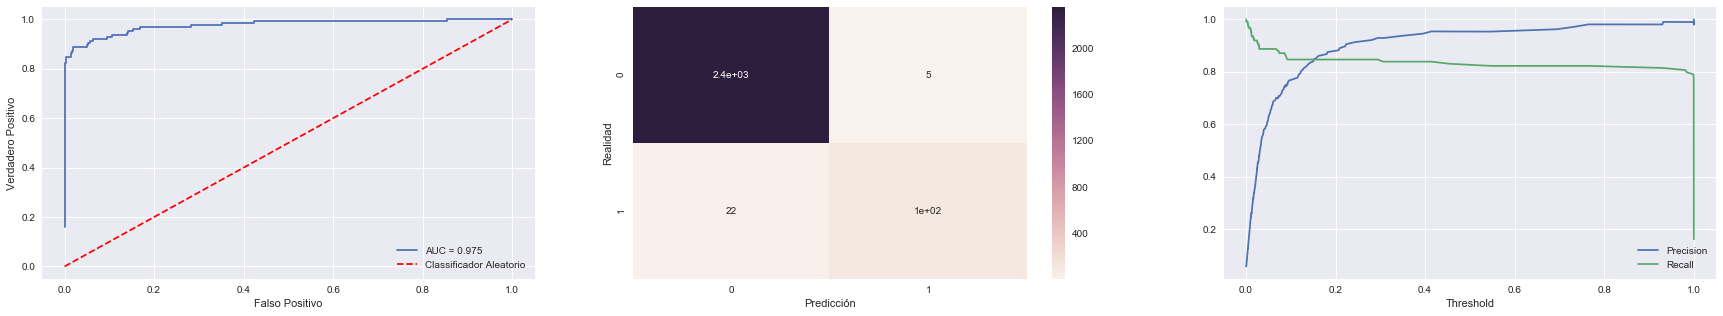

In [169]:
## Aplicamos la función logística sin balancear datos solo fijamos nuestro set_seed para controla la aleatoriedad, y
## validación cruzada con fold = 10, y que seleecione a traves de mejor área bajo la curva ('roc-auc') 
## ver otros scoring: ('http://scikit-learn.org/stable/modules/model_evaluation.html#scoring').
RL1 = LogisticRegression(random_state = set_seed) 
RL1.CV = RFECV(RL1, cv = 10, scoring = 'roc_auc')
## Fuente: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
RL1.CV.fit(train_X, train_y)

prob_y = RL1.CV.predict_proba(test_X)
model_graf_metrics(RL1.CV, test_y, prob_y)

In [206]:
resultados_csv(RL1.CV, datatest, 'RegLogUnbalced')

             precision    recall  f1-score   support

          0       0.99      0.97      0.98      2359
          1       0.59      0.88      0.71       124

avg / total       0.97      0.96      0.97      2483



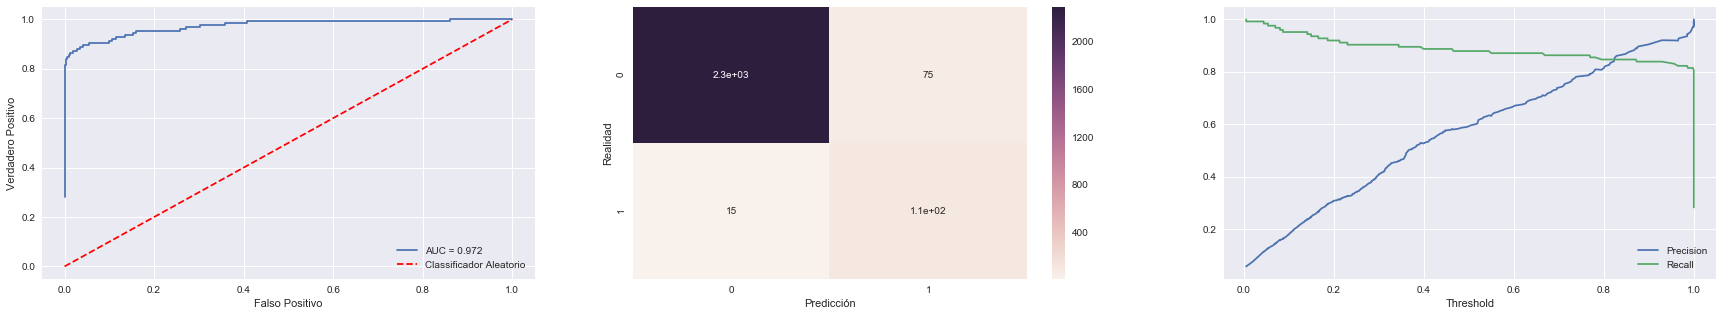

In [171]:
## Aplicamos la función logística con los datos balanceados utilizando un argumento dentro de la regresión lógistica
## "" class_weight = 'balanced' "".
RL2 = LogisticRegression(random_state = set_seed, class_weight = 'balanced')
RL2.CV = RFECV(RL2, cv = 10, scoring = 'roc_auc')
RL2.CV.fit(train_X, train_y)

prob_y = RL2.CV.predict_proba(test_X)
model_graf_metrics(RL2.CV, test_y, prob_y)

In [207]:
resultados_csv(RL2.CV, datatest, 'RegLogBalced')

Se puede apreciar que el primer modelo (Sin balancear los datos) otorga un poco más de precisoón en la predicción en ambas curvas.

### Random Forest
El siguiente modelo es el de boseques aleatorios, es una combinación de árboles de decision solo que para cada árbol depende de los valores de un vector aleatorio probado independientemente y con la misma distribución para cada uno de estos hasta ajustarse a los datos, de ese modo hay que controlar los parámetros de forma óptima para evitar el sobreajustes.

In [149]:
RF = RandomForestClassifier(random_state = set_seed)
## Fuente: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## Asígnamos rangos amplios de parámetros para evaluar
grid_param = {'max_depth': range(1, 100, 10),
              'min_samples_leaf': range(5, 200, 10),
              'min_samples_split': range(5, 100, 10)}
RF.CV = GridSearchCV(estimator = RF, cv = 10, scoring = 'roc_auc', param_grid = grid_param, n_jobs = 4)
## Fuente: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

## Probamos el fit y obtenemos la mejor selección del GridSearchCV
RF.CV.fit(train_X, train_y)
print(RF.CV.best_params_)

{'max_depth': 11, 'min_samples_leaf': 15, 'min_samples_split': 5}


             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2359
          1       0.99      0.80      0.88       124

avg / total       0.99      0.99      0.99      2483



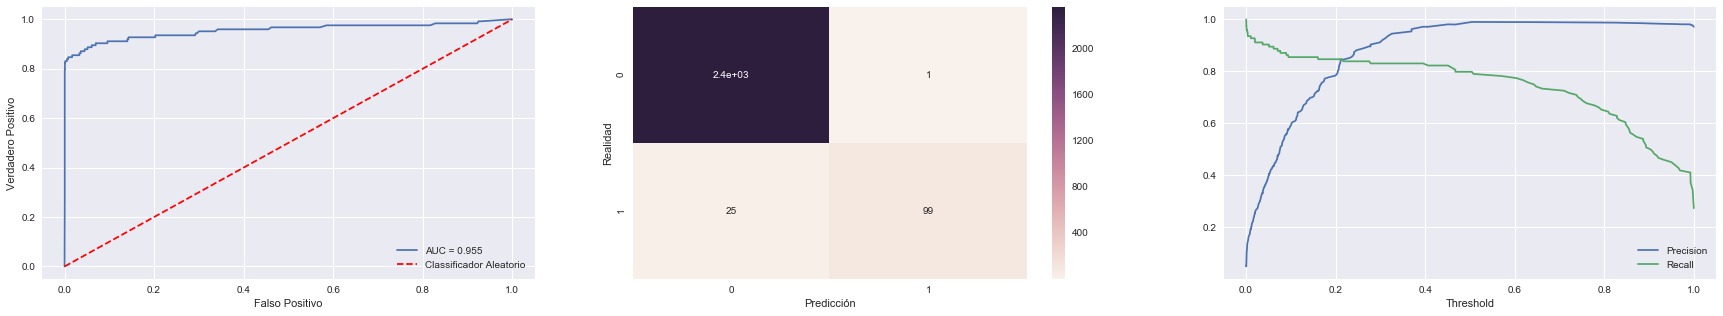

In [172]:
## Del anterior paso obetenemos que la mejor combinacion de paramétros que nos ofrece el GridSearchCV es:
## {'max_depth': 11, 'min_samples_leaf': 15, 'min_samples_split': 5}

## Aplicamos los parámetros obtenido para obtener los resultados
RF1 = RandomForestClassifier(random_state = set_seed, max_depth = 11, min_samples_leaf = 15, min_samples_split = 5)
RF1.CV = RFECV(RF1, cv = 10, scoring = 'roc_auc')
RF1.CV.fit(train_X, train_y)

prob_y = RF1.CV.predict_proba(test_X)
model_graf_metrics(RF1.CV, test_y, prob_y)

In [208]:
resultados_csv(RF1.CV, datatest, 'RFUnbalced')

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2359
          1       0.89      0.84      0.86       124

avg / total       0.99      0.99      0.99      2483



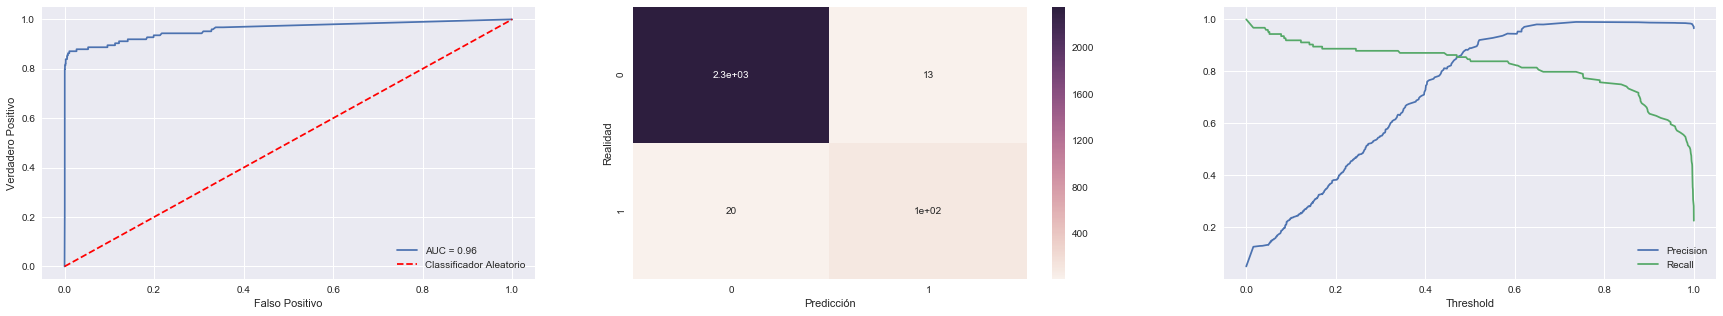

In [174]:
## Aplicamos los parámetros obtenido para obtener los resultados, ahora balancendo los datos
RF2 = RandomForestClassifier(random_state = set_seed, class_weight = 'balanced',
                             max_depth = 11, min_samples_leaf = 15, min_samples_split = 5)
RF2.CV = RFECV(RF2, cv = 10, scoring = 'roc_auc')
RF2.CV.fit(train_X, train_y)

prob_y = RF2.CV.predict_proba(test_X)
model_graf_metrics(RF2.CV, test_y, prob_y)

In [209]:
resultados_csv(RF2.CV, datatest, 'RFBalced')

### SVM
SVM (Support Vector Machine) ser caracteriza por buscar un hiperplano que separe de forma óptima a los puntos de una clase de la de otra, que eventualmente han podido ser previamente proyectados a un espacio de dimensionalidad superior, por lo cual puede ser muy ótipo para este caso en que los datos aparentemente ya han sido preprocesados por PCA.

En ese concepto de "separación óptima" es donde reside la característica fundamental de las SVM: este tipo de algoritmos buscan el hiperplano que tenga la máxima distancia (margen) con los puntos que estén más cerca de él mismo. Por eso también a veces se les conoce a las SVM como clasificadores de margen máximo. De esta forma, los puntos del vector que son etiquetados con una categoría estarán a un lado del hiperplano y los casos que se encuentren en la otra categoría estarán al otro lado.

In [183]:
SVM = SVC(random_state = set_seed)
## Fuente: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## Asígnamos rangos amplios de parámetros para evaluar
grid_param_svm = {'C': range(1, 10, 1)}
SVM.CV = GridSearchCV(estimator = SVM, cv = 10, scoring = 'roc_auc', param_grid = grid_param_svm, n_jobs = 4)
## Fuente: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

## Probamos el fit y obtenemos la mejor selección del GridSearchCV
SVM.CV.fit(train_X, train_y)
print(SVM.CV.best_params_)

{'C': 8}


             precision    recall  f1-score   support

          0       0.99      1.00      1.00      2359
          1       0.99      0.82      0.90       124

avg / total       0.99      0.99      0.99      2483



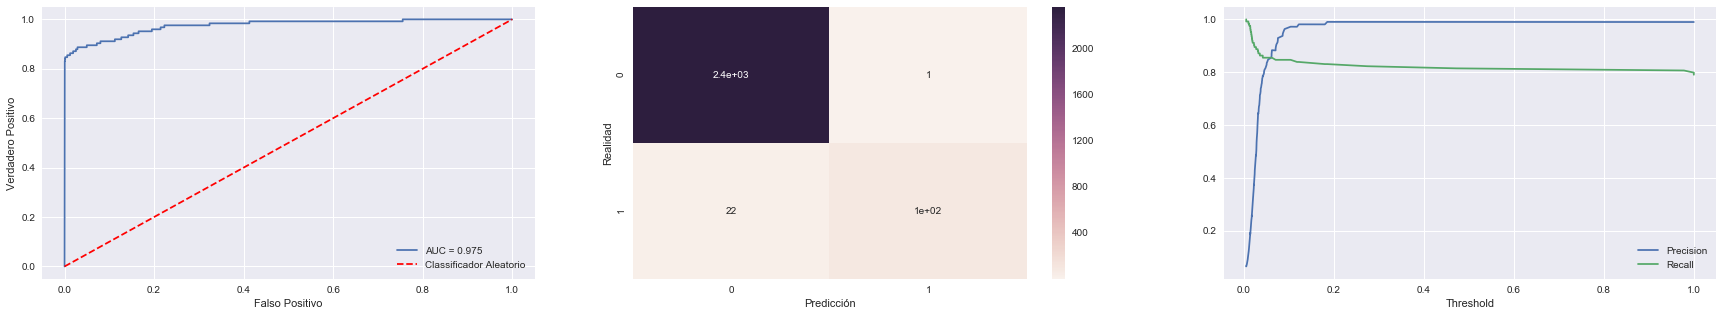

In [188]:
## Del anterior paso obetenemos que la mejor combinacion de paramétros que nos ofrece el GridSearchCV es:
## {'C': 8}

## Aplicamos los parámetros obtenido para obtener los resultados
SVM1 = SVC(random_state = set_seed, C = 8, kernel = 'linear', probability = True)
## parece que solo nos funciona con un Kernel = 'linear'
SVM1.CV = RFECV(SVM1, cv = 10, scoring = 'roc_auc')
SVM1.CV.fit(train_X, train_y)

prob_y = SVM1.CV.predict_proba(test_X)
model_graf_metrics(SVM1.CV, test_y, prob_y)

In [210]:
resultados_csv(SVM1.CV, datatest, 'SVMUnbalced')

             precision    recall  f1-score   support

          0       0.99      0.97      0.98      2359
          1       0.63      0.87      0.73       124

avg / total       0.97      0.97      0.97      2483



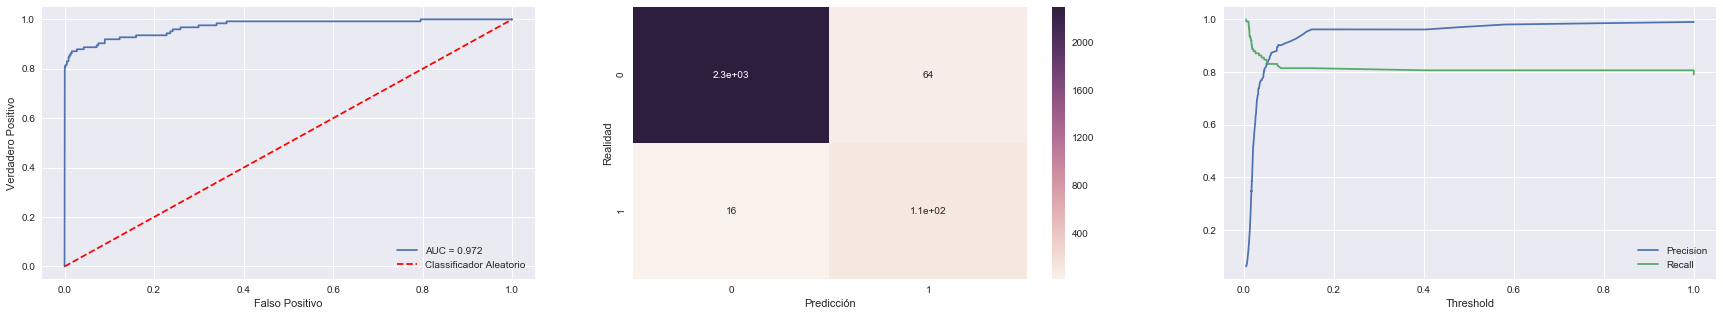

In [189]:
## Aplicamos los parámetros obtenido para obtener los resultados, ahora con los datos balaceados
SVM2 = SVC(random_state = set_seed, C = 8, kernel = 'linear', probability = True, class_weight = 'balanced')
## parece que solo nos funciona con un Kernel = 'linear'
SVM2.CV = RFECV(SVM2, cv = 10, scoring = 'roc_auc')
SVM2.CV.fit(train_X, train_y)

prob_y = SVM2.CV.predict_proba(test_X)
model_graf_metrics(SVM2.CV, test_y, prob_y)

In [211]:
resultados_csv(SVM2.CV, datatest, 'SVMBalced')

### Conclusión
La conclusión que más podriamos destacar es que las predicciones que mejores resultados dan sobre los datos de entrenamiento son los modelos sin el ajuste que utilizamos para banlancearlos. Por otro lado cabe decir que el modelo más simple a priori proporciona unos resultado tan buenos como los modelos más complejos, habrá que ver como se comportan ante la verdadera prueba de evaluación.

Fijandonos en los valores de la matrices de confusión, observamos que el que mejor classifica sobre la partición de test es el modelo más complejo, el SVM (Support Vector Machine) SIN el ajuste "class_weight = 'balanced'" seguido de la primera regresión logística que clasifican 23 y 27 observaciones de forma errónea, respectivamente.